In [1]:
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
import TheoryCL

## Calculate the ISW and matter auto and cross angular power spectra

In [2]:
SCL = TheoryCL.SourceCL()

# Set cosmology
SCL.cosmo(omega_m=0.25, omega_l=0.75, h0=0.7, omega_b=0.044, ns=0.95, As=2.45e-9, sigma8=0.8)

# Creates a table of the following linear growth functions for later interpolation:
# - r : comoving distance
# - H : Hubble parameter
# - D : linear growth rate
# - f : dlnD/dlna via approximation.
SCL.calc_table(zmin=0., zmax=10., zbin_num=10000, zbin_mode='log')

# Calculates the linear power spectra using CAMB and create callable interpolator.
SCL.calc_pk()

lmax = 700 # maximum l mode to compute CLs.
zmin = 0. # minimum redshift integrals along the line-of-sight are computed to.
zmax = 5. # maximum redshift to which integrals along the line-of-sight are computed to.
rbin_num = 1000 # number of bins along radial coordinates for integration.
rbin_mode = 'linear' # linear or log binning schemes.
kmin = None # minimum k for integrals, if None defaults to minimum value pre-calculated by CAMB.
kmax = 1. # maximum k for integrals
kbin_num = 1000 # number of bins in Fourier coordinates for integration.
kbin_mode = 'log' # linear or log binning schemes.
switch2limber = 30 # beyond this l we only compute the CLs using the Limber approximation.
SCL.setup(lmax, zmin=zmin, zmax=zmax, rbin_num=rbin_num, rbin_mode=rbin_mode,
          kmin=kmin, kmax=kmax, kbin_num=kbin_num, kbin_mode=kbin_mode,
          switch2limber=switch2limber)

# Define sources, for example the ISW and matter distribution between redshift 0 and 1.4.

zmin, zmax = 0., 1.4
SCL.set_source_ISW(zmin, zmax)
SCL.set_source_gal_tophat(zmin, zmax, 1.) # the 1. is the linear bias

SCL.get_CL()

# The CLs can be called:

CL_full = SCL.CLs_full # no Limber approximation for l <= switch2limber
CL_approx = SCL.CLs_approx # Limber approximation

# Lastly no limber for l <= switch2limber and then Limber approximation with
# amplitude correction calculated from the ratio of the full and limber approximation
# for switch2limber - 5 <= l <= switch2limber.
CL = SCL.CLs

Calculating Cls (Full)    L = 30 / 30 : |##################################################| 100% 
Calculating Cls (Approx.) L = 700 / 700 : |##################################################| 100% 


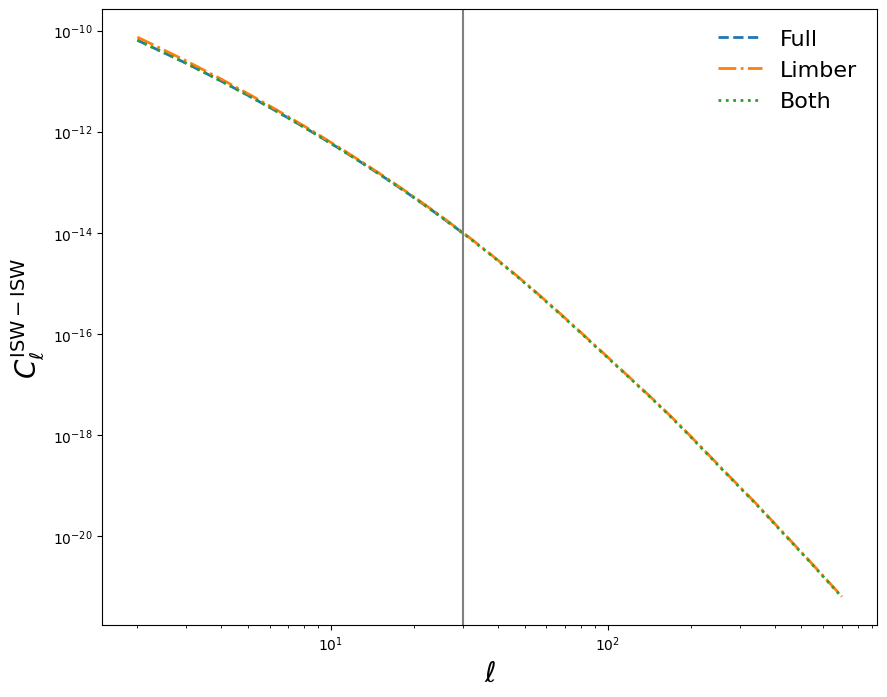

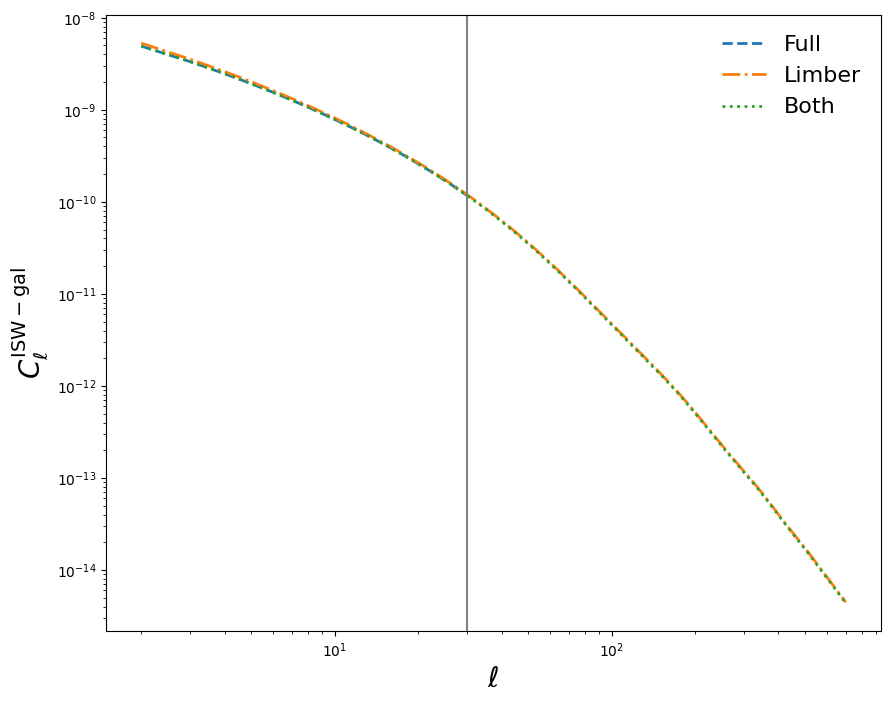

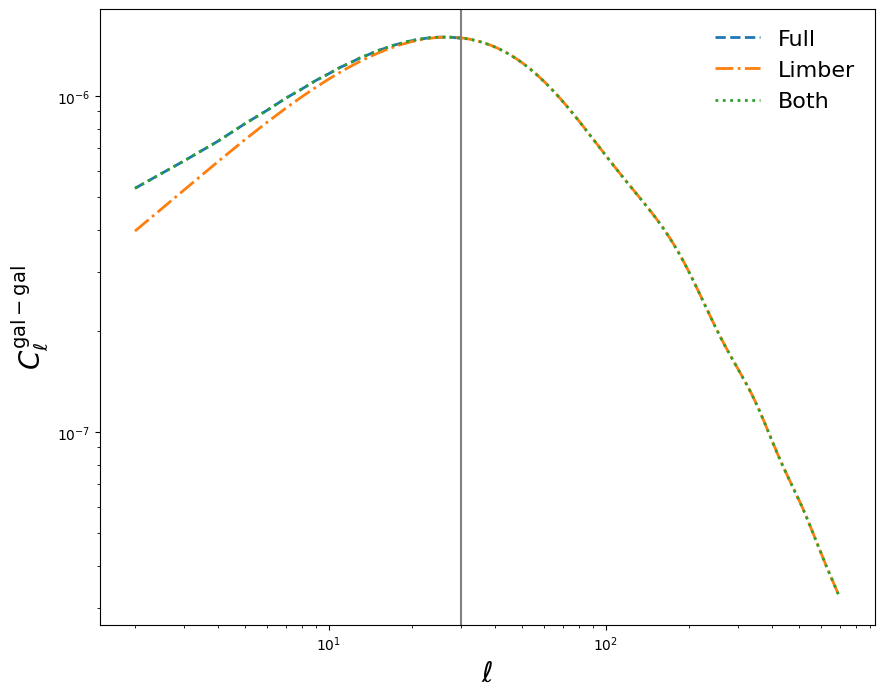

In [3]:
for i in range(0, len(SCL.sources_X)):

    CL_type = SCL.sources_dict['source '+str(SCL.sources_X[i])]['source type']+'-'+SCL.sources_dict['source '+str(SCL.sources_Y[i])]['source type']
    
    plt.figure(figsize=(10., 8.))
    plt.plot(SCL.L_full, SCL.CLs_full[:, i], color='C0', linestyle='--', linewidth=2., label='Full')
    plt.plot(SCL.L, SCL.CLs_approx[:, i], color='C1', linestyle='-.', linewidth=2., label='Limber')
    plt.plot(SCL.L, SCL.CLs[:, i], color='C2', linestyle=':', linewidth=2., label='Both')
    plt.axvline(SCL.switch2limber, color='grey')
    plt.xlabel(r'$\ell$', fontsize=20)
    plt.ylabel(r'$C_{\ell}^{\rm %s}$' % CL_type, fontsize=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='best', fontsize=16, frameon=False)
    plt.savefig('plots/cl_'+CL_type+'.png', dpi=100)
    plt.show()

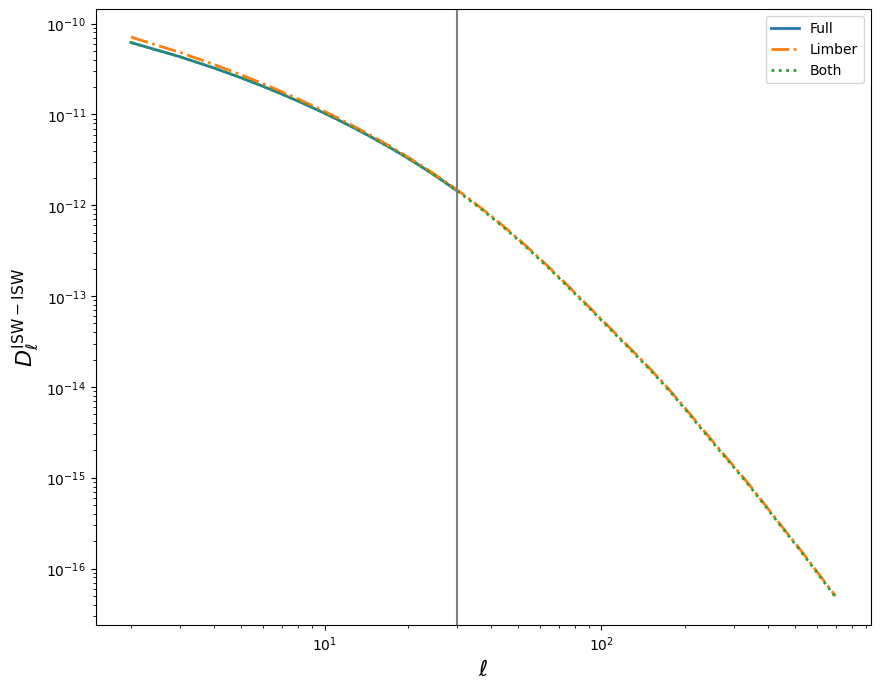

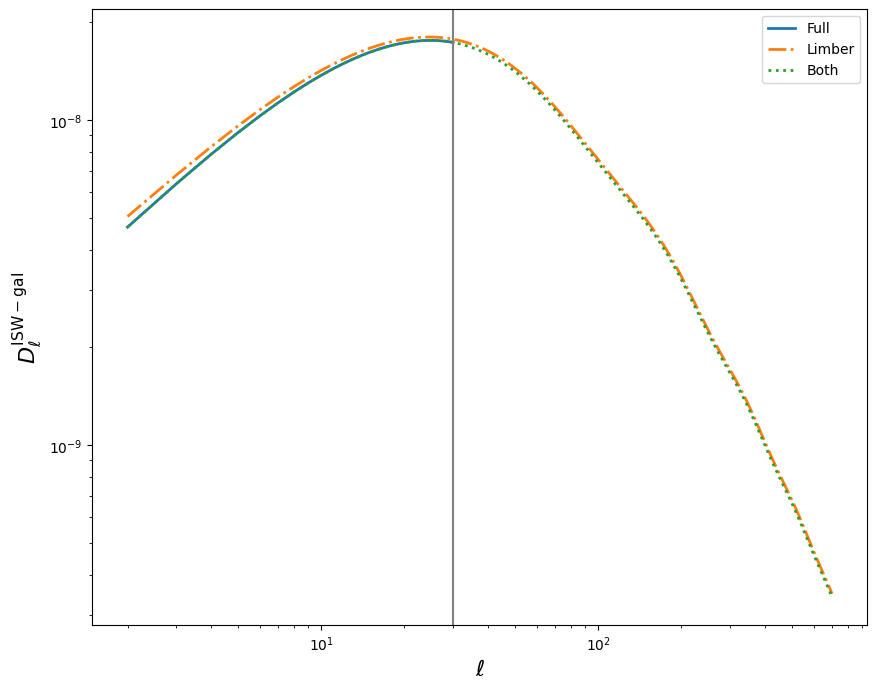

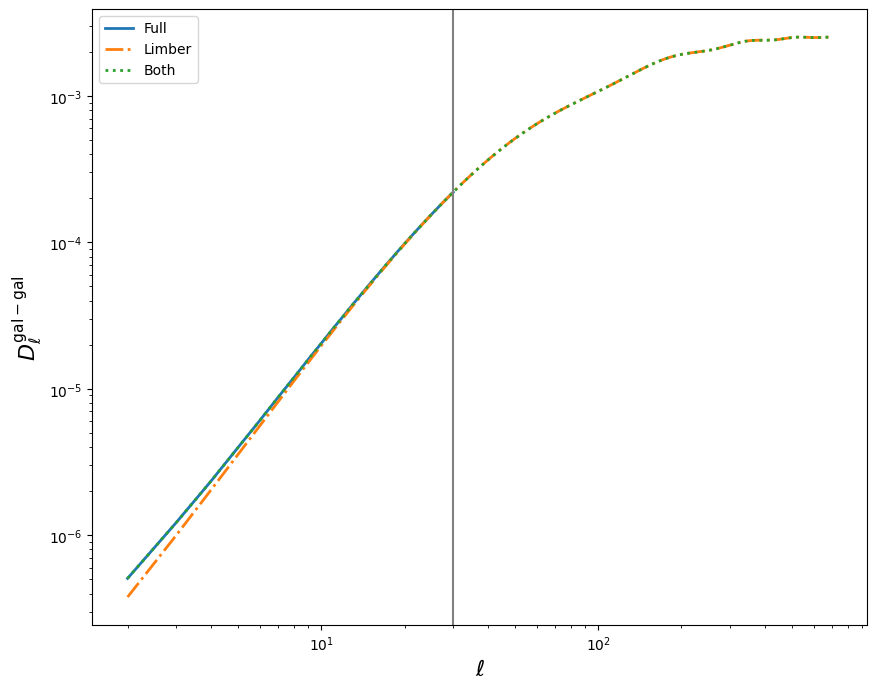

In [4]:
# ...or plot Dls
SCL.get_DL()

for i in range(0, len(SCL.sources_X)):
    
    CL_type = SCL.sources_dict['source '+str(SCL.sources_X[i])]['source type']+'-'+SCL.sources_dict['source '+str(SCL.sources_Y[i])]['source type']
    
    plt.figure(figsize=(10., 8.))
    plt.plot(SCL.L_full, SCL.DLs_full[:, i], color='C0', linestyle='-', linewidth=2., label='Full')
    plt.plot(SCL.L, SCL.DLs_approx[:, i], color='C1', linestyle='-.', linewidth=2., label='Limber')
    plt.plot(SCL.L, SCL.DLs[:, i], color='C2', linestyle=':', linewidth=2., label='Both')
    plt.axvline(SCL.switch2limber, color='grey')
    plt.xlabel(r'$\ell$', fontsize=16)
    plt.ylabel(r'$D_{\ell}^{\rm %s}$' % CL_type, fontsize=16)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()

## Simulate correlated ISW and matter healpix maps

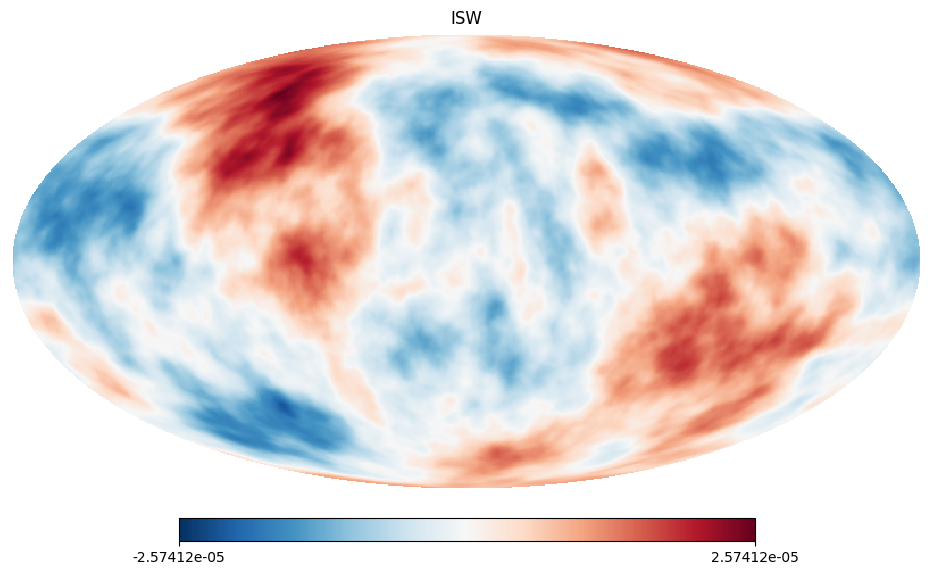

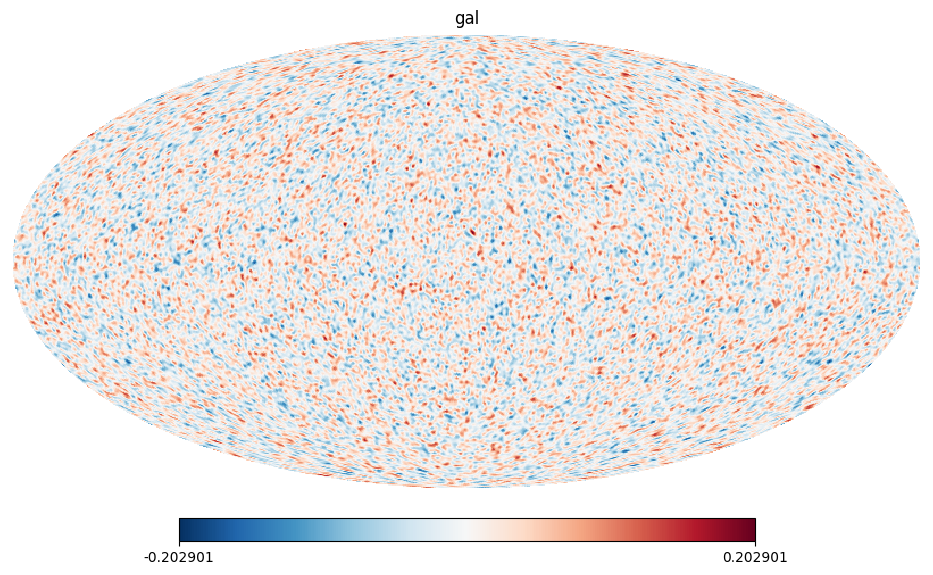

In [5]:
SCL.prep4heal() # prepare CLs for healpy.

# Simulate healpix maps with the theoretical CLs calculated with:
sim_nside = 256 # healpix nside
sim_lmax = 200 # maximum l

SCL.simulate(sim_lmax, sim_nside)

cmap = plt.cm.RdBu_r # colormap for Healpix plots below.

for i in range(0, SCL.source_count):

    plt.figure(figsize=(12, 6))
    hp.mollview(SCL.sim_maps[i], cmap=cmap, min=-abs(SCL.sim_maps[i]).max(), max=abs(SCL.sim_maps[i]).max(), 
                fig=1, title=SCL.sources_dict['source '+str(i+1)]['source type'])
    plt.savefig('plots/maps_'+SCL.sources_dict['source '+str(i+1)]['source type']+'.png', dpi=100)
    plt.show()

## Redefine sources to include sample $N(z)$

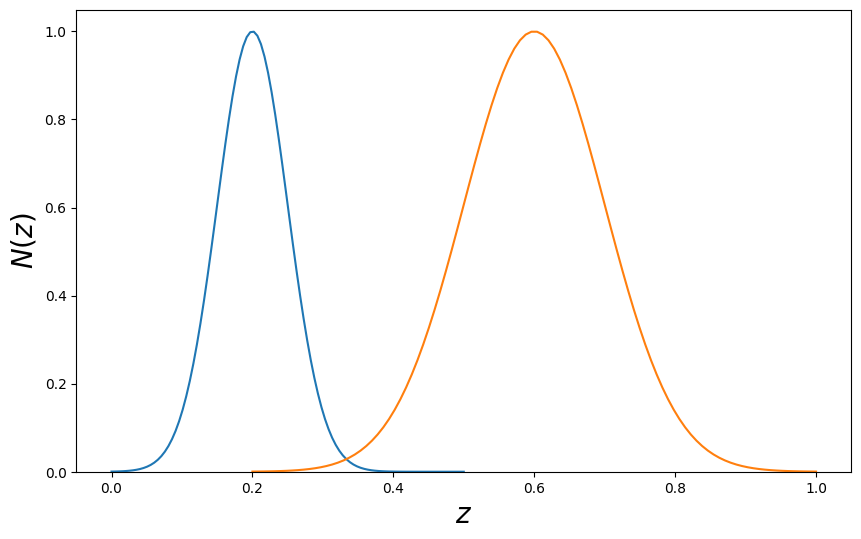

In [6]:
# Using sample defined Nz, take for example two distributions with Gaussian N(z).

z1 = np.linspace(0., 0.5, 100)
nz1 = np.exp(-0.5 * ((0.2 - z1)**2.) / (0.05**2.))

z2 = np.linspace(0.2, 1., 100)
nz2 = np.exp(-0.5 * ((0.6 - z2)**2.) / (0.1**2.))

# We don't need to worry about normalising these n(z) as this is handled by TheoryCL.

plt.figure(figsize=(10., 6.))
plt.plot(z1, nz1)
plt.plot(z2, nz2)
plt.xlabel(r'$z$', fontsize=20)
plt.ylabel(r'$N(z)$', fontsize=20)
plt.ylim(0., None)
plt.show()

In [7]:
SCL.clean_sources()

zmin, zmax = 0., 1.
SCL.set_source_ISW(zmin, zmax)
SCL.set_source_gal_sample(z1, nz1)
SCL.set_source_gal_sample(z2, nz2)

SCL.get_CL()

Calculating Cls (Full)    L = 30 / 30 : |##################################################| 100% 
Calculating Cls (Approx.) L = 700 / 700 : |##################################################| 100% 


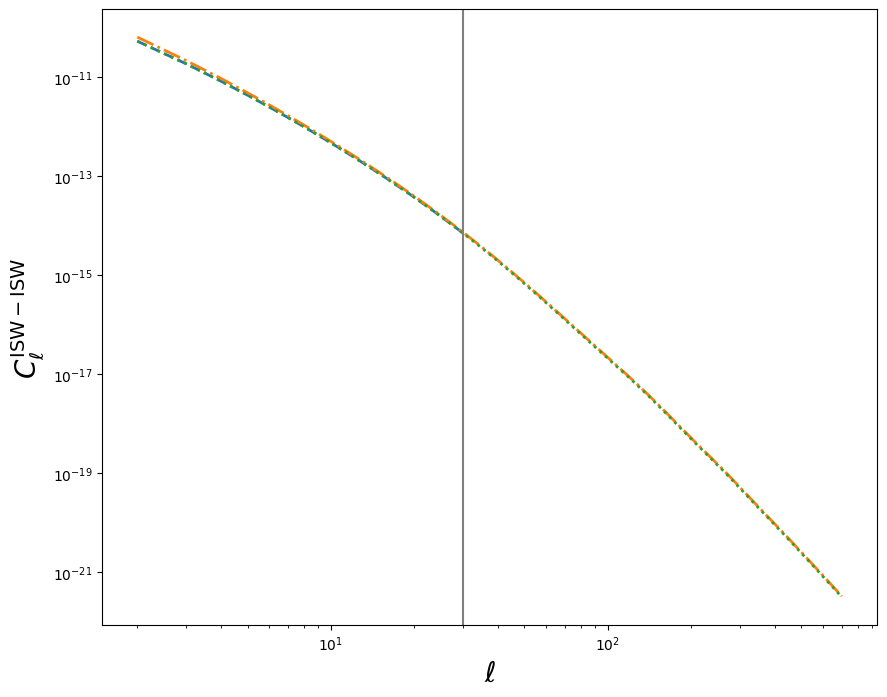

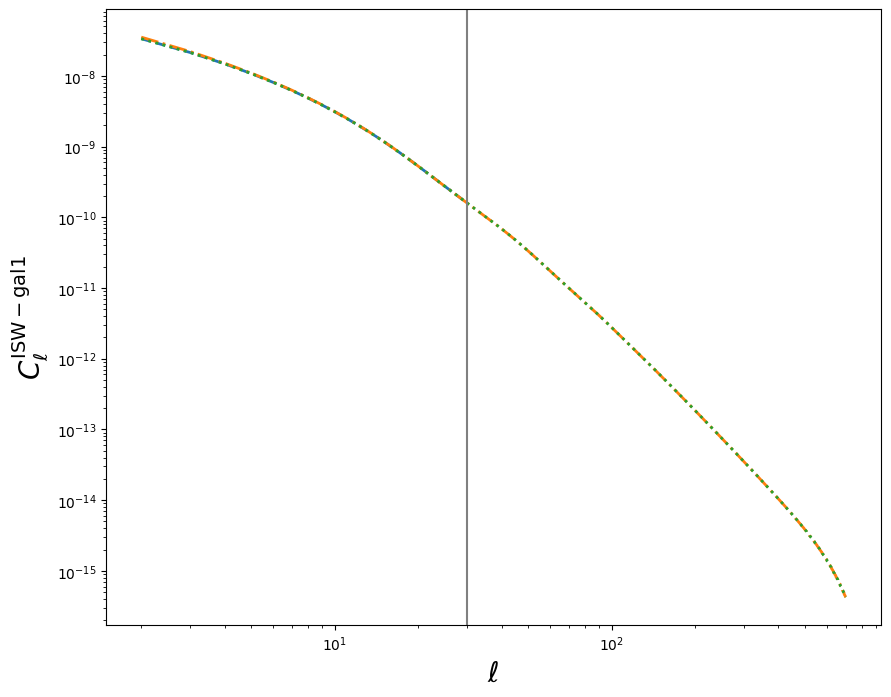

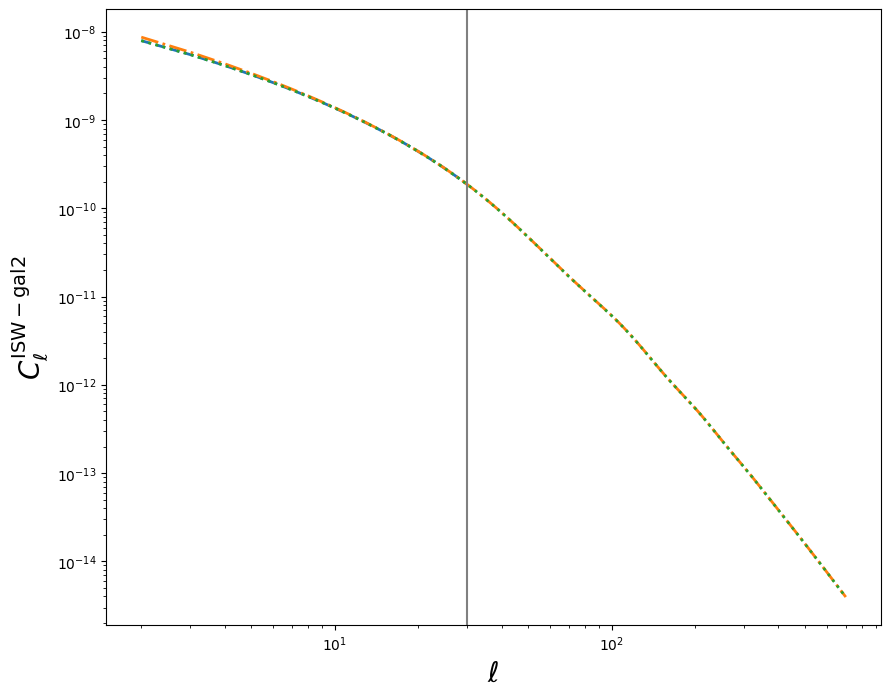

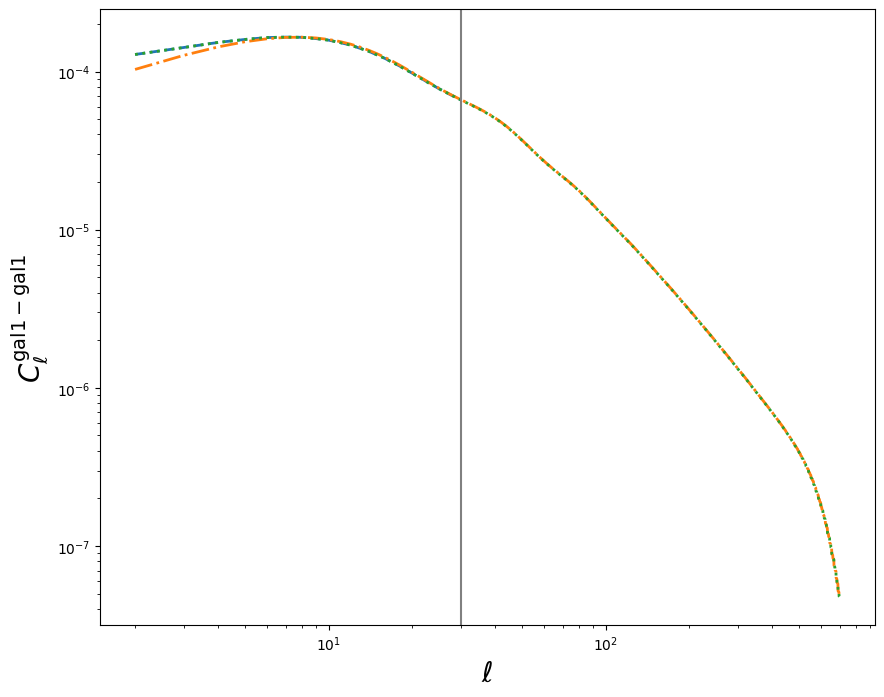

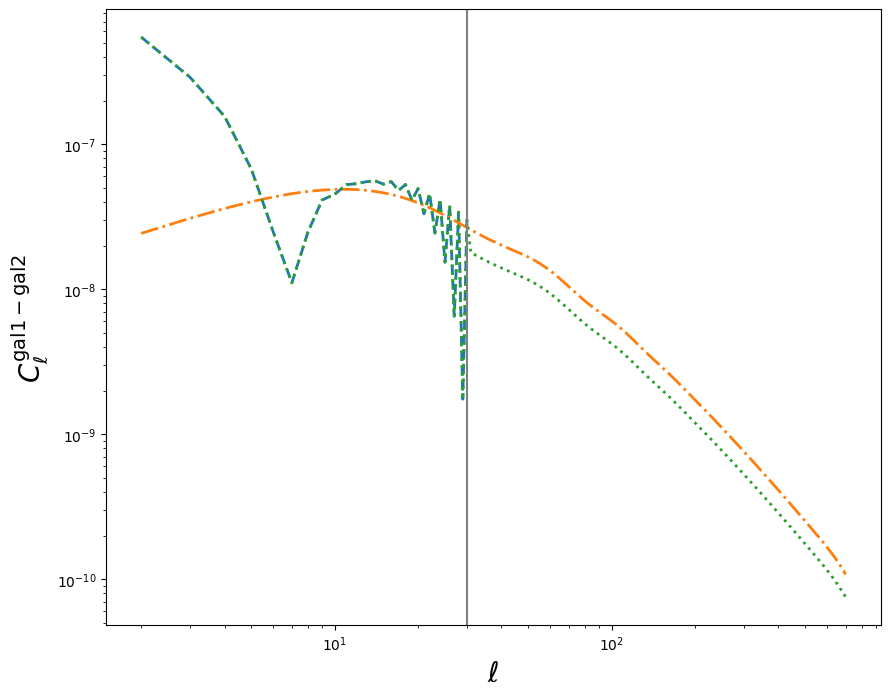

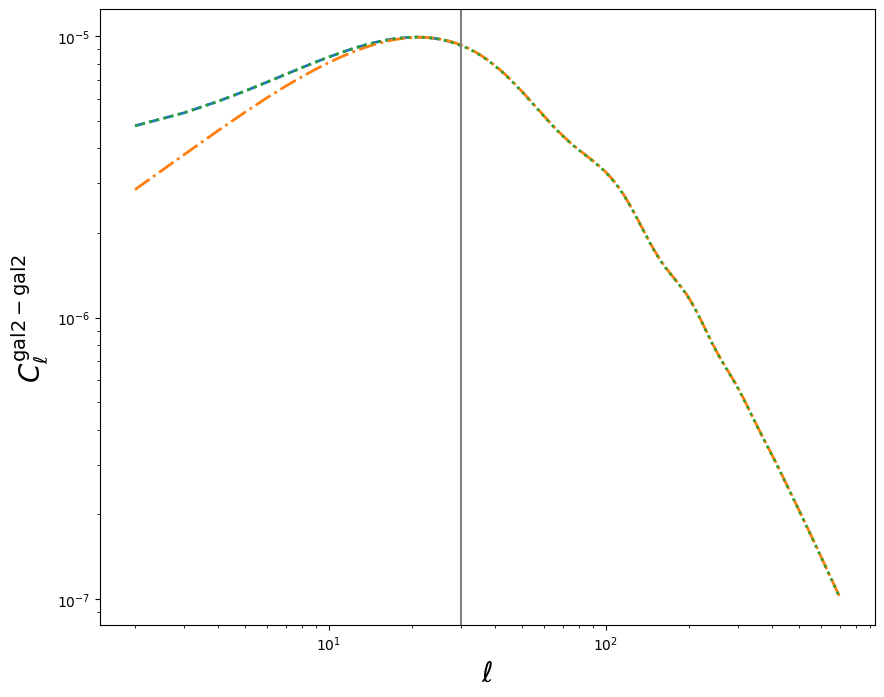

In [9]:
for i in range(0, len(SCL.sources_X)):
    
    if SCL.sources_dict['source '+str(SCL.sources_X[i])]['source type'] == 'gal' and SCL.sources_dict['source '+str(SCL.sources_Y[i])]['source type'] == 'gal':
        CL_type = SCL.sources_dict['source '+str(SCL.sources_X[i])]['source type']+str(SCL.sources_X[i]-1)+'-'+SCL.sources_dict['source '+str(SCL.sources_Y[i])]['source type']+str(SCL.sources_Y[i]-1)
    elif SCL.sources_dict['source '+str(SCL.sources_X[i])]['source type'] == 'gal':
        CL_type = SCL.sources_dict['source '+str(SCL.sources_X[i])]['source type']+str(SCL.sources_X[i]-1)+'-'+SCL.sources_dict['source '+str(SCL.sources_Y[i])]['source type']
    elif SCL.sources_dict['source '+str(SCL.sources_Y[i])]['source type'] == 'gal':
        CL_type = SCL.sources_dict['source '+str(SCL.sources_X[i])]['source type']+'-'+SCL.sources_dict['source '+str(SCL.sources_Y[i])]['source type']+str(SCL.sources_Y[i]-1) 
    else:
        CL_type = SCL.sources_dict['source '+str(SCL.sources_X[i])]['source type']+'-'+SCL.sources_dict['source '+str(SCL.sources_Y[i])]['source type']
    
    plt.figure(figsize=(10., 8.))
    plt.plot(SCL.L_full, abs(SCL.CLs_full[:, i]), color='C0', linestyle='--', linewidth=2.)
    plt.plot(SCL.L, abs(SCL.CLs_approx[:, i]), color='C1', linestyle='-.', linewidth=2.)
    plt.plot(SCL.L, abs(SCL.CLs[:, i]), color='C2', linestyle=':', linewidth=2.)
    plt.axvline(SCL.switch2limber, color='grey')
    plt.xlabel(r'$\ell$', fontsize=20)
    plt.ylabel(r'$C_{\ell}^{\rm %s}$' % CL_type, fontsize=20)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

/var/folders/nf/t2czqs3j4fj1t6zvl01sq2180000gn/T/ipykernel_36172/734429413.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


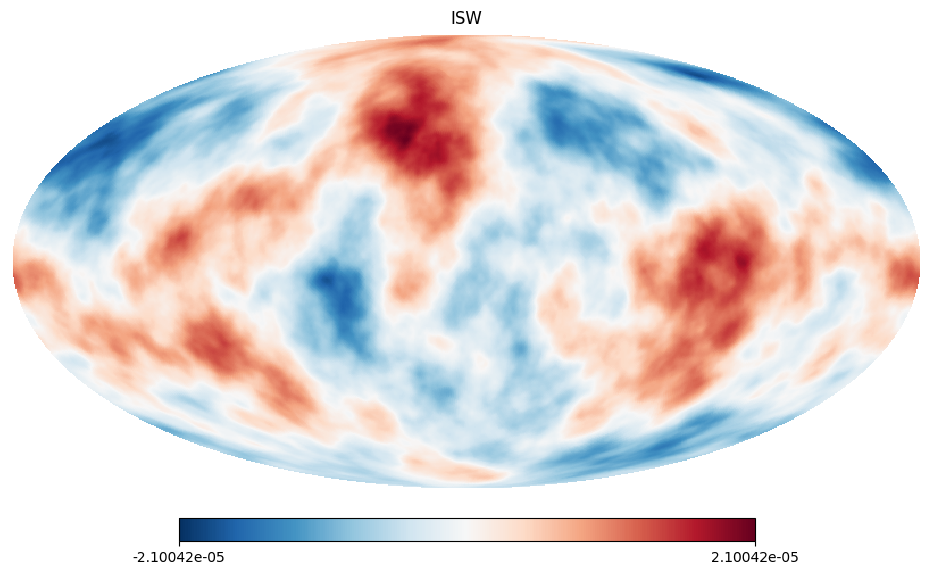

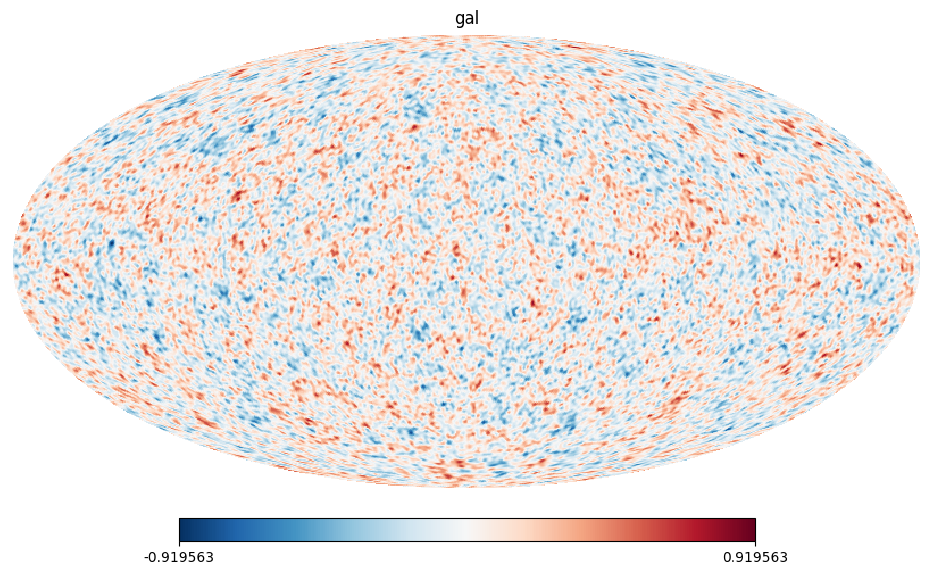

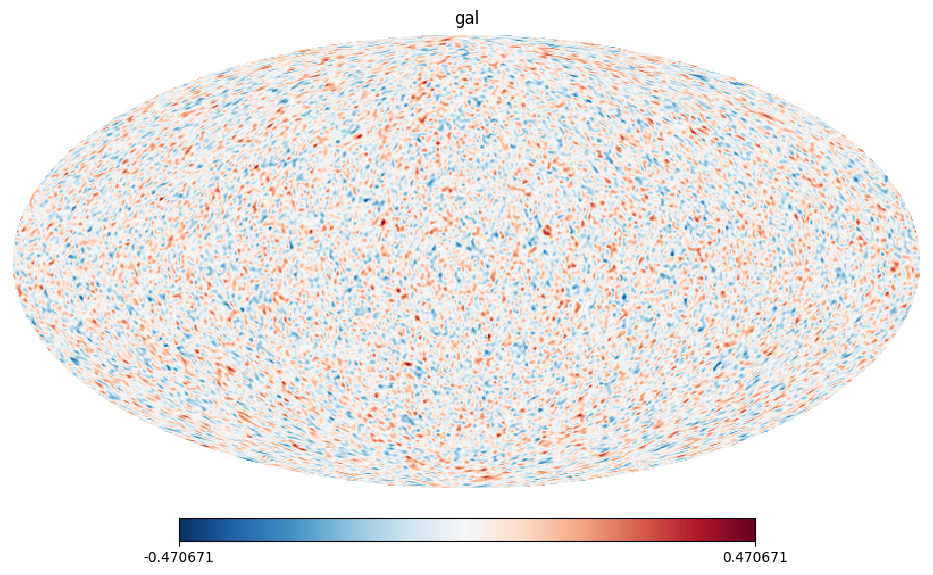

In [10]:
SCL.prep4heal() # prepare CLs for healpy.

# Simulate healpix maps with the theoretical CLs calculated with:
sim_nside = 256 # healpix nside
sim_lmax = 200 # maximum l

SCL.simulate(sim_lmax, sim_nside)

cmap = plt.cm.RdBu_r # colormap for Healpix plots below.

for i in range(0, SCL.source_count):

    plt.figure(figsize=(12, 6))
    hp.mollview(SCL.sim_maps[i], cmap=cmap, min=-abs(SCL.sim_maps[i]).max(), max=abs(SCL.sim_maps[i]).max(), fig=1, title=SCL.sources_dict['source '+str(i+1)]['source type'])
    plt.tight_layout()
    plt.show()